# Data Science 2 - final project results - team 11: Barack Samuni & Barak Yaakov
***

In [72]:
import os
import pandas as pd
from src.team_11.task7.task7 import extract_hebrew_content
from task7.task7 import translate_dataframe
from src.team_1.hospital_models.generic_torch_model import ClassificationPipeline,ClassificationVisualization
from task21.task21 import *
import seaborn as sns
from src.team_1.task_9.generic_eda import GenericEDA
import torch

## Task 7: Data cleaning and completion for table: hospitalization2
***

first, let's view the data:



In [73]:
# The data is present in the data folder two directories up
data_dir = os.path.abspath(os.path.join(os.getcwd(),"..","data"))
dataset_path = os.path.join(data_dir, "rehospitalization.xlsx")

# read the Excel file 
hospitalization_df = pd.read_excel(dataset_path,sheet_name='hospitalization2')
hospitalization_df.head()

,Patient,unitName1,Admission_Medical_Record,Admission_Entry_Date,Release_Date,unitName2,Admission_Medical_Record2,Admission_Entry_Date2,Release_Date2,סוג קבלה,מהיכן המטופל הגיע,Release_Type,רופא משחרר,ימי אשפוז,אבחנות בקבלה,אבחנות בשחרור,מחלקות מייעצות,ct
0,430047,5,4727327,2021-02-16 17:33:45.570,2021-02-19 12:40:00,5,4745943,2021-02-24 15:03:30.490,2021-02-25 12:38:00,דחוף,מביתו,שוחרר לביתו,11023.0,1,"5370 , 7872 , 78720","5370 , 7872 , 78720",NaN,0
1,447962,4,6084166,2022-08-07 13:27:58.780,2022-08-08 15:15:00,4,6137129,2022-09-01 04:20:51.617,2022-09-02 16:00:00,דחוף,מביתו,שוחרר לביתו,12517.0,1,78060,78060,ריפוי בעיסוק,0
2,214558,5,7164813,2023-10-27 07:34:41.013,2023-10-29 17:18:00,5,7172678,2023-10-30 17:58:09.730,2023-11-01 15:33:00,דחוף,מביתו,שוחרר לביתו,11887.0,2,5119,"5119 , 514",שירות דיאטה,0
3,71277,3,4295329,2020-07-29 17:00:56.863,2020-08-03 14:26:00,3,4354333,2020-08-30 04:25:30.670,2020-09-03 13:45:00,דחוף,מביתו,שוחרר לביתו,10525.0,4,"2859 , 7807","486 , 5990",".שרות לפיזיותרפיה , מערך אורתופדי",0
4,112016,1,5052676,2021-07-03 11:42:24.973,2021-07-05 17:34:00,1,5078317,2021-07-13 01:21:32.077,2021-07-15 11:48:00,דחוף,מביתו,שוחרר לביתו,6890.0,2,7865,7865,"קרדיולוגיה- יעוצים , שירות דיאטה",1


let's check for missing values:

In [74]:
hospitalization_df[hospitalization_df.isna().any(axis=1)]

,Patient,unitName1,Admission_Medical_Record,Admission_Entry_Date,Release_Date,unitName2,Admission_Medical_Record2,Admission_Entry_Date2,Release_Date2,סוג קבלה,מהיכן המטופל הגיע,Release_Type,רופא משחרר,ימי אשפוז,אבחנות בקבלה,אבחנות בשחרור,מחלקות מייעצות,ct
0,430047,5,4727327,2021-02-16 17:33:45.570,2021-02-19 12:40:00,5,4745943,2021-02-24 15:03:30.490,2021-02-25 12:38:00,דחוף,מביתו,שוחרר לביתו,11023.0,1,"5370 , 7872 , 78720","5370 , 7872 , 78720",NaN,0
7,184878,2,6918151,2023-07-09 23:35:15.747,2023-07-10 14:59:00,2,6986186,2023-08-05 18:31:45.557,2023-08-06 17:08:00,דחוף,מביתו,שוחרר לביתו,11360.0,1,"2761 , 4019","2761 , 4019",NaN,0
10,357262,1,3883573,2020-01-06 17:15:08.367,2020-01-12 14:31:00,1,3949224,2020-02-03 20:39:27.760,2020-02-05 14:20:00,דחוף,מביתו,שוחרר לביתו,10762.0,2,78060,"27651 , 78060",NaN,0
13,873826,2,6565058,2023-02-22 22:11:22.987,2023-02-24 15:02:00,2,6572876,2023-02-26 15:50:32.377,2023-02-27 11:57:00,דחוף,מביתו,שוחרר לביתו,NaN,1,7807,7807,המטואונקולוגיה,0
17,664036,2,6956039,2023-07-24 10:33:56.947,2023-07-25 09:15:00,2,7007093,2023-08-13 17:05:14.897,2023-08-15 14:30:00,דחוף,אחר,שוחרר לביתו,11233.0,2,NaN,376010,"מיון עיניים , מכון דיאליזה",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8896,71734,5,5336066,2021-10-31 20:00:03.300,2021-11-05 14:26:00,5,5396084,2021-11-23 19:43:21.260,2021-12-03 13:10:00,דחוף,מביתו,שוחרר למוסד,NaN,10,"4280 , 514 , 7802",", 4280 , 514 , 7802",".שרות לפיזיותרפיה , פנימית ו , שירות דיאטה , ...",0
8897,185319,1,4521799,2020-11-18 22:15:47.687,2020-11-22 16:41:00,1,4537552,2020-11-25 14:15:30.023,2020-11-27 14:00:00,דחוף,מביתו,שוחרר לביתו,11178.0,2,4280,"4280 , 5119",NaN,0
8898,706750,4,4701708,2021-02-06 15:17:41.530,2021-02-08 13:34:00,4,4716334,2021-02-11 18:55:10.857,2021-02-13 17:30:00,דחוף,מביתו,שוחרר למוסד,10989.0,2,2859,4280,NaN,0
8907,951,5,5011100,2021-06-16 20:07:56.080,2021-06-17 16:35:00,5,5089310,2021-07-16 20:04:44.397,2021-07-18 14:24:00,דחוף,מביתו,שוחרר לביתו,10946.0,2,486,486,NaN,0


we can see that we have missing values. For example, in מחלקות מעייצות let's see what percentage of the data is missing, and also let's check what columns are missing. Before that, it would be nice to know what are the data types of the columns:


In [75]:
hospitalization_df.dtypes

Patient                               int64
unitName1                             int64
Admission_Medical_Record              int64
Admission_Entry_Date         datetime64[ns]
Release_Date                 datetime64[ns]
unitName2                             int64
Admission_Medical_Record2             int64
Admission_Entry_Date2        datetime64[ns]
Release_Date2                datetime64[ns]
סוג קבלה                             object
מהיכן המטופל הגיע                    object
Release_Type                         object
רופא משחרר                          float64
ימי אשפוז                             int64
אבחנות בקבלה                         object
אבחנות בשחרור                        object
מחלקות מייעצות                       object
ct                                    int64
dtype: object

In [76]:
hospitalization_df.isna().sum()

Patient                         0
unitName1                       0
Admission_Medical_Record        0
Admission_Entry_Date            0
Release_Date                    0
unitName2                       0
Admission_Medical_Record2       0
Admission_Entry_Date2           0
Release_Date2                   0
סוג קבלה                       68
מהיכן המטופל הגיע               0
Release_Type                    0
רופא משחרר                     88
ימי אשפוז                       0
אבחנות בקבלה                  802
אבחנות בשחרור                 233
מחלקות מייעצות               4176
ct                              0
dtype: int64

we can see that we have missing values in "סוג קבלה" which is an object (categorical variable), in רופא משחרר (float64, numerical variable) in אבחנות בקבלה and אבחנות בשחרור (both are objects, categorical variables) and in מחלקות מייעצות (also a categorical variable). let's check what percentage of the data is missing:

In [77]:
print(f'{hospitalization_df.isna().sum().sum() / hospitalization_df.size * 100:.2f} % of the data is missing')

3.34 % of the data is missing


Well, after giving it much thought, we decided to drop the missing values. The reason behind that is that any way to impute these values would lead to critical misinformation that might skew the model's predictions into making hazardous false decisions regarding the patient. Since less than 5% of the data is missing, we feel free to drop it without the risk of underfitting the model.

In [78]:
hospitalization_df_clean = hospitalization_df.dropna()
hospitalization_df_clean.isna().sum()

Patient                      0
unitName1                    0
Admission_Medical_Record     0
Admission_Entry_Date         0
Release_Date                 0
unitName2                    0
Admission_Medical_Record2    0
Admission_Entry_Date2        0
Release_Date2                0
סוג קבלה                     0
מהיכן המטופל הגיע            0
Release_Type                 0
רופא משחרר                   0
ימי אשפוז                    0
אבחנות בקבלה                 0
אבחנות בשחרור                0
מחלקות מייעצות               0
ct                           0
dtype: int64

Now let's translate the dataframe to english, first let's check where we have hebrew:

In [79]:
hebrew_dict = extract_hebrew_content(hospitalization_df_clean)
print(f'{hebrew_dict}')

{'columns': ['סוג קבלה', 'מהיכן המטופל הגיע', 'רופא משחרר', 'ימי אשפוז', 'אבחנות בקבלה', 'אבחנות בשחרור', 'מחלקות מייעצות'], 'content': ['דחוף', 'מוזמן', 'אשפוז יום', 'מביתו', 'ממוסד', 'אחר', 'מבית חולים אחר', 'ממרפאה', 'שוחרר לביתו', 'שוחרר למוסד', 'ריפוי בעיסוק', 'שירות דיאטה', 'שרות לפיזיותרפיה', 'מערך אורתופדי', 'קרדיולוגיה- יעוצים', 'קרדיולוגיה הפרעות קצב', 'טיפול נמרץ כללי-יעוצים', 'שרות פסיכיאטריה', 'גסטרואנטרולוגיה מכון', 'מחלות זיהומיות', 'המטואונקולוגיה', 'ניתוחי עמוד שדרה', 'אחות ריאות', 'כירורגית א', 'מחלקת ריאות', 'מכון לתפקודי ריאה', 'מיון עיניים', 'פסיכיאטריה', 'מיון כירורגי', 'מכון דיאליזה', 'כירורגית ב', 'מחלקת אף אוזן גרון', 'שירות לעבודה סוציאלית', 'קלינאי תקשורת', 'מחלקת נוירולוגיה', 'שירותי רוקחות', 'מכון אנדוקרינולוגי', 'טיפול נמרץ נשימתי', 'מכון EEG', 'וועדת וויסות', 'פנימית ו', 'טיפול נמרץ', 'קרדיולוגיה-קוצבים', 'פיזיותרפיה וסטיבולרי - יעוצים', 'מכון אונקולוגי-יעוץ-לא פעיל', 'מרפאה אונקולוגית', 'מרפאת ראומטולוגיה', 'מתאמת פצעים', 'הרדמה', 'מרפאת עור', 'מחלקת אור

Now let's translate the dataset:

In [80]:
hospitalization_df_clean_translated = translate_dataframe(hospitalization_df_clean)
hospitalization_df_clean_translated.to_excel(r'task7/hospitalization2_translated_clean.xlsx',sheet_name='hospitalization2')

## Task21- finding a relationship between discharging department and rehospitalization
***

In [81]:
## Load the clean hospitalization dataset
clean_hospitazation2_dir = os.path.abspath(os.path.join(os.getcwd(),"..","data"))
clean_hospitazation2_path = os.path.join(clean_hospitazation2_dir,"hospitalization2_Team_10.csv")
clean_hospitazation2_df = pd.read_csv(clean_hospitazation2_path)
clean_hospitazation2_df.head()

,Patient,unitName1,Admission_Medical_Record,Admission_Entry_Date,Release_Date,unitName2,Admission_Medical_Record2,Admission_Entry_Date2,Release_Date2,Entry_Type,Patient_Origin,Release_Type,Releasing_Doctor,Admission_Days2,Diagnosis_In_Reception,Diagnosis_In_Release,ct
0,430047,5,4727327,2021-02-16 17:33:45.570,2021-02-19 12:40:00,5,4745943,2021-02-24 15:03:30.490,2021-02-25 12:38:00,urgent,home,home,11023,1,"5370 , 7872 , 78720","5370 , 7872 , 78720",0
1,447962,4,6084166,2022-08-07 13:27:58.780,2022-08-08 15:15:00,4,6137129,2022-09-01 04:20:51.617,2022-09-02 16:00:00,urgent,home,home,12517,1,78060,78060,0
2,214558,5,7164813,2023-10-27 07:34:41.013,2023-10-29 17:18:00,5,7172678,2023-10-30 17:58:09.730,2023-11-01 15:33:00,urgent,home,home,11887,2,5119,"5119 , 514",0
3,71277,3,4295329,2020-07-29 17:00:56.863,2020-08-03 14:26:00,3,4354333,2020-08-30 04:25:30.670,2020-09-03 13:45:00,urgent,home,home,10525,4,"2859 , 7807","486 , 5990",0
4,112016,1,5052676,2021-07-03 11:42:24.973,2021-07-05 17:34:00,1,5078317,2021-07-13 01:21:32.077,2021-07-15 11:48:00,urgent,home,home,6890,2,7865,7865,1


first, let's find the time elapsed from the first hospitalization to the 2nd one. In order to determine how long it took for a patient to be re-hospitalized, we will calculate the difference between the Release_Date (from the first hospitalization) to the Admission_Entry_Date2 (when the patient entered the hospital once again for hospitalization) and add it as a column called "Days_To_Rehospitalization":

In [82]:
clean_hospitazation2_df_with_rehospitalization_time = clean_hospitazation2_df.copy()
release_date = clean_hospitazation2_df_with_rehospitalization_time['Release_Date']
admission_date_2 = clean_hospitazation2_df_with_rehospitalization_time['Admission_Entry_Date2']
clean_hospitazation2_df_with_rehospitalization_time['Days_To_Rehospitalization'] = Task21.calculate_time_differences_between_columns(column1=release_date, column2=admission_date_2)
clean_hospitazation2_df_with_rehospitalization_time.head()

,Patient,unitName1,Admission_Medical_Record,Admission_Entry_Date,Release_Date,unitName2,Admission_Medical_Record2,Admission_Entry_Date2,Release_Date2,Entry_Type,Patient_Origin,Release_Type,Releasing_Doctor,Admission_Days2,Diagnosis_In_Reception,Diagnosis_In_Release,ct,Days_To_Rehospitalization
0,430047,5,4727327,2021-02-16 17:33:45.570,2021-02-19 12:40:00,5,4745943,2021-02-24 15:03:30.490,2021-02-25 12:38:00,urgent,home,home,11023,1,"5370 , 7872 , 78720","5370 , 7872 , 78720",0,5.099658
1,447962,4,6084166,2022-08-07 13:27:58.780,2022-08-08 15:15:00,4,6137129,2022-09-01 04:20:51.617,2022-09-02 16:00:00,urgent,home,home,12517,1,78060,78060,0,23.545736
2,214558,5,7164813,2023-10-27 07:34:41.013,2023-10-29 17:18:00,5,7172678,2023-10-30 17:58:09.730,2023-11-01 15:33:00,urgent,home,home,11887,2,5119,"5119 , 514",0,1.027890
3,71277,3,4295329,2020-07-29 17:00:56.863,2020-08-03 14:26:00,3,4354333,2020-08-30 04:25:30.670,2020-09-03 13:45:00,urgent,home,home,10525,4,"2859 , 7807","486 , 5990",0,26.582994
4,112016,1,5052676,2021-07-03 11:42:24.973,2021-07-05 17:34:00,1,5078317,2021-07-13 01:21:32.077,2021-07-15 11:48:00,urgent,home,home,6890,2,7865,7865,1,7.324677


let's check if that calculation did not accidentally create some missing values:

In [83]:
clean_hospitazation2_df_with_rehospitalization_time.isna().sum()

Patient                      0
unitName1                    0
Admission_Medical_Record     0
Admission_Entry_Date         0
Release_Date                 0
unitName2                    0
Admission_Medical_Record2    0
Admission_Entry_Date2        0
Release_Date2                0
Entry_Type                   0
Patient_Origin               0
Release_Type                 0
Releasing_Doctor             0
Admission_Days2              0
Diagnosis_In_Reception       0
Diagnosis_In_Release         0
ct                           0
Days_To_Rehospitalization    0
dtype: int64

let's save it as a csv:

In [84]:
clean_hospitazation2_df_with_rehospitalization_time.to_csv(r'task21/hospitalization2_translated_clean_with_reshospitalization_time.csv',index=False)

we need to build a classifier that classifies the time it is going to take for patient to be re-hospitalized according to the unit he has released from. We see that we have UnitName and UnitName2. Let's check if they are identical, and if they do, we will merge them into one column called 'Discharging Unit':

In [85]:
clean_hospitazation2_df_with_rehospitalization_time_discharging_unit_combined = clean_hospitazation2_df_with_rehospitalization_time.copy()
Task21.merge_two_columns_if_identical(df=clean_hospitazation2_df_with_rehospitalization_time_discharging_unit_combined, column1='unitName1', column2='unitName2',target_column='Discharging Unit')
clean_hospitazation2_df_with_rehospitalization_time_discharging_unit_combined.to_csv(r'task21/hospitalization2_translated_clean_with_reshospitalization_time_discharging_unit_combined.csv',index=False)
clean_hospitazation2_df_with_rehospitalization_time_discharging_unit_combined.head()


,Patient,Discharging Unit,Admission_Medical_Record,Admission_Entry_Date,Release_Date,Admission_Medical_Record2,Admission_Entry_Date2,Release_Date2,Entry_Type,Patient_Origin,Release_Type,Releasing_Doctor,Admission_Days2,Diagnosis_In_Reception,Diagnosis_In_Release,ct,Days_To_Rehospitalization
0,430047,5,4727327,2021-02-16 17:33:45.570,2021-02-19 12:40:00,4745943,2021-02-24 15:03:30.490,2021-02-25 12:38:00,urgent,home,home,11023,1,"5370 , 7872 , 78720","5370 , 7872 , 78720",0,5.099658
1,447962,4,6084166,2022-08-07 13:27:58.780,2022-08-08 15:15:00,6137129,2022-09-01 04:20:51.617,2022-09-02 16:00:00,urgent,home,home,12517,1,78060,78060,0,23.545736
2,214558,5,7164813,2023-10-27 07:34:41.013,2023-10-29 17:18:00,7172678,2023-10-30 17:58:09.730,2023-11-01 15:33:00,urgent,home,home,11887,2,5119,"5119 , 514",0,1.027890
3,71277,3,4295329,2020-07-29 17:00:56.863,2020-08-03 14:26:00,4354333,2020-08-30 04:25:30.670,2020-09-03 13:45:00,urgent,home,home,10525,4,"2859 , 7807","486 , 5990",0,26.582994
4,112016,1,5052676,2021-07-03 11:42:24.973,2021-07-05 17:34:00,5078317,2021-07-13 01:21:32.077,2021-07-15 11:48:00,urgent,home,home,6890,2,7865,7865,1,7.324677


Now, let's divide the time deltas into classes, first let's try to boxplot our target variable (Days_To_Rehospitalization) to see what we're dealing with)

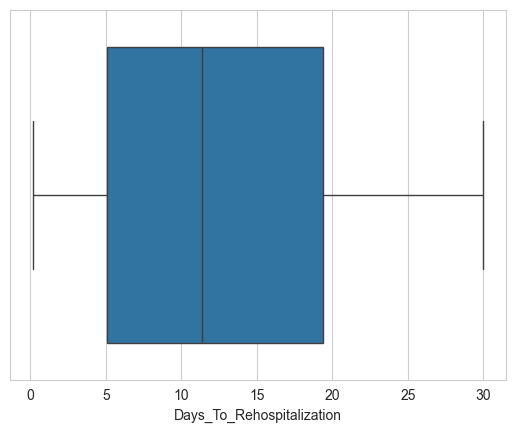

In [86]:
sns.boxplot(x=clean_hospitazation2_df_with_rehospitalization_time_discharging_unit_combined['Days_To_Rehospitalization']);

ok, so we can see that our median is approximately 12, the 25th quartile is at 5, and the 75th quartile is at approximately 18. Also, we have no outliers (which is great!). However, we are trying to label the data into 3 classes as even as possible, so we would like to divide the data into 3 quartiles:


In [87]:
target_for_discharging_unit = clean_hospitazation2_df_with_rehospitalization_time_discharging_unit_combined['Days_To_Rehospitalization']
print(f'33th quantile is: {target_for_discharging_unit.quantile(1 / 3)}\n')
print(f'66th quantile is: {target_for_discharging_unit.quantile(2 / 3)}\n')
print(f'99th quantile is: {target_for_discharging_unit.quantile(1)}\n')


33th quantile is: 6.894788491512345

66th quantile is: 16.37814055941358

99th quantile is: 29.9977434375



we can use these stats in order to label our target:


In [88]:
clean_hospitazation2_df_with_rehospitalization_time_discharging_unit_combined_labeled =  Task21.label_data(df=clean_hospitazation2_df_with_rehospitalization_time_discharging_unit_combined, column_to_label='Days_To_Rehospitalization', labels=['Short', 'Medium', 'Long'])
clean_hospitazation2_df_with_rehospitalization_time_discharging_unit_combined_labeled.to_csv(r'task21/hospitalization2_translated_clean_with_reshospitalization_time_discharging_unit_combined_labeled.csv',index=False)
clean_hospitazation2_df_with_rehospitalization_time_discharging_unit_combined_labeled.head()

,Patient,Discharging Unit,Admission_Medical_Record,Admission_Entry_Date,Release_Date,Admission_Medical_Record2,Admission_Entry_Date2,Release_Date2,Entry_Type,Patient_Origin,Release_Type,Releasing_Doctor,Admission_Days2,Diagnosis_In_Reception,Diagnosis_In_Release,ct,Days_To_Rehospitalization
0,430047,5,4727327,2021-02-16 17:33:45.570,2021-02-19 12:40:00,4745943,2021-02-24 15:03:30.490,2021-02-25 12:38:00,urgent,home,home,11023,1,"5370 , 7872 , 78720","5370 , 7872 , 78720",0,Short
1,447962,4,6084166,2022-08-07 13:27:58.780,2022-08-08 15:15:00,6137129,2022-09-01 04:20:51.617,2022-09-02 16:00:00,urgent,home,home,12517,1,78060,78060,0,Long
2,214558,5,7164813,2023-10-27 07:34:41.013,2023-10-29 17:18:00,7172678,2023-10-30 17:58:09.730,2023-11-01 15:33:00,urgent,home,home,11887,2,5119,"5119 , 514",0,Short
3,71277,3,4295329,2020-07-29 17:00:56.863,2020-08-03 14:26:00,4354333,2020-08-30 04:25:30.670,2020-09-03 13:45:00,urgent,home,home,10525,4,"2859 , 7807","486 , 5990",0,Long
4,112016,1,5052676,2021-07-03 11:42:24.973,2021-07-05 17:34:00,5078317,2021-07-13 01:21:32.077,2021-07-15 11:48:00,urgent,home,home,6890,2,7865,7865,1,Medium


let's check the histogram of our categorical column:

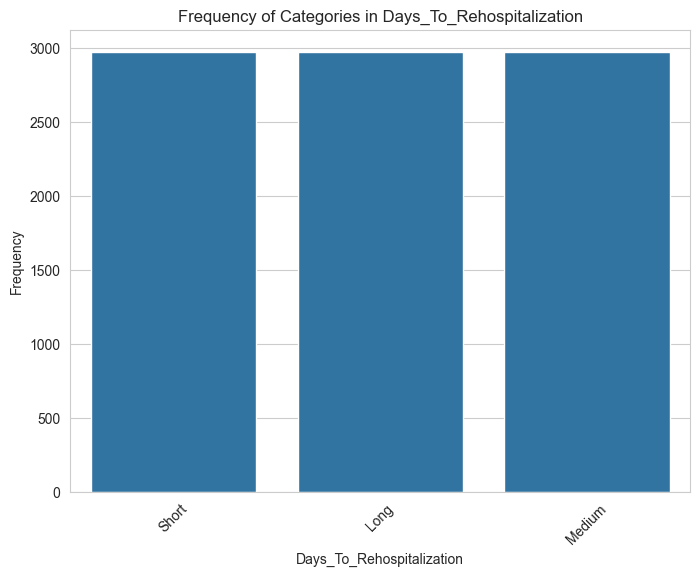

In [89]:
time_for_rehospitalization_eda = GenericEDA(clean_hospitazation2_df_with_rehospitalization_time_discharging_unit_combined_labeled)
time_for_rehospitalization_eda.plot_categorical_frequency('Days_To_Rehospitalization')

we can see, that we got even groups as we wanted :)
Now let's check the correlation matrix for this dataset:

In [90]:
clean_hospitazation2_df_with_rehospitalization_time_discharging_unit_combined_labeled_encoded = clean_hospitazation2_df_with_rehospitalization_time_discharging_unit_combined_labeled.copy()
classification_report_for_rehospitalization = ClassificationPipeline(df=clean_hospitazation2_df_with_rehospitalization_time_discharging_unit_combined_labeled_encoded,features=['Discharging Unit'], target='Days_To_Rehospitalization')
clean_hospitazation2_df_with_rehospitalization_time_discharging_unit_combined_labeled_encoded['Days_To_Rehospitalization'] = classification_report_for_rehospitalization.encode_target()
clean_hospitazation2_df_with_rehospitalization_time_discharging_unit_combined_labeled_encoded.head()

,Patient,Discharging Unit,Admission_Medical_Record,Admission_Entry_Date,Release_Date,Admission_Medical_Record2,Admission_Entry_Date2,Release_Date2,Entry_Type,Patient_Origin,Release_Type,Releasing_Doctor,Admission_Days2,Diagnosis_In_Reception,Diagnosis_In_Release,ct,Days_To_Rehospitalization
0,430047,5,4727327,2021-02-16 17:33:45.570,2021-02-19 12:40:00,4745943,2021-02-24 15:03:30.490,2021-02-25 12:38:00,urgent,home,home,11023,1,"5370 , 7872 , 78720","5370 , 7872 , 78720",0,2
1,447962,4,6084166,2022-08-07 13:27:58.780,2022-08-08 15:15:00,6137129,2022-09-01 04:20:51.617,2022-09-02 16:00:00,urgent,home,home,12517,1,78060,78060,0,0
2,214558,5,7164813,2023-10-27 07:34:41.013,2023-10-29 17:18:00,7172678,2023-10-30 17:58:09.730,2023-11-01 15:33:00,urgent,home,home,11887,2,5119,"5119 , 514",0,2
3,71277,3,4295329,2020-07-29 17:00:56.863,2020-08-03 14:26:00,4354333,2020-08-30 04:25:30.670,2020-09-03 13:45:00,urgent,home,home,10525,4,"2859 , 7807","486 , 5990",0,0
4,112016,1,5052676,2021-07-03 11:42:24.973,2021-07-05 17:34:00,5078317,2021-07-13 01:21:32.077,2021-07-15 11:48:00,urgent,home,home,6890,2,7865,7865,1,1


The data was encoded that way: 
* 2 = short
* 1 = Medium
* 0 = Long

Since our target represents elapsed time, it makes sense to encode it in an ordinal way (since Long is further from Short than from Medium).Now let's plot a correlation matrix for our target:

C:\DS2-final_project\data-science2-lab-final-project\src\team_1\task_9\generic_eda.py:100: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = self.df.corr()


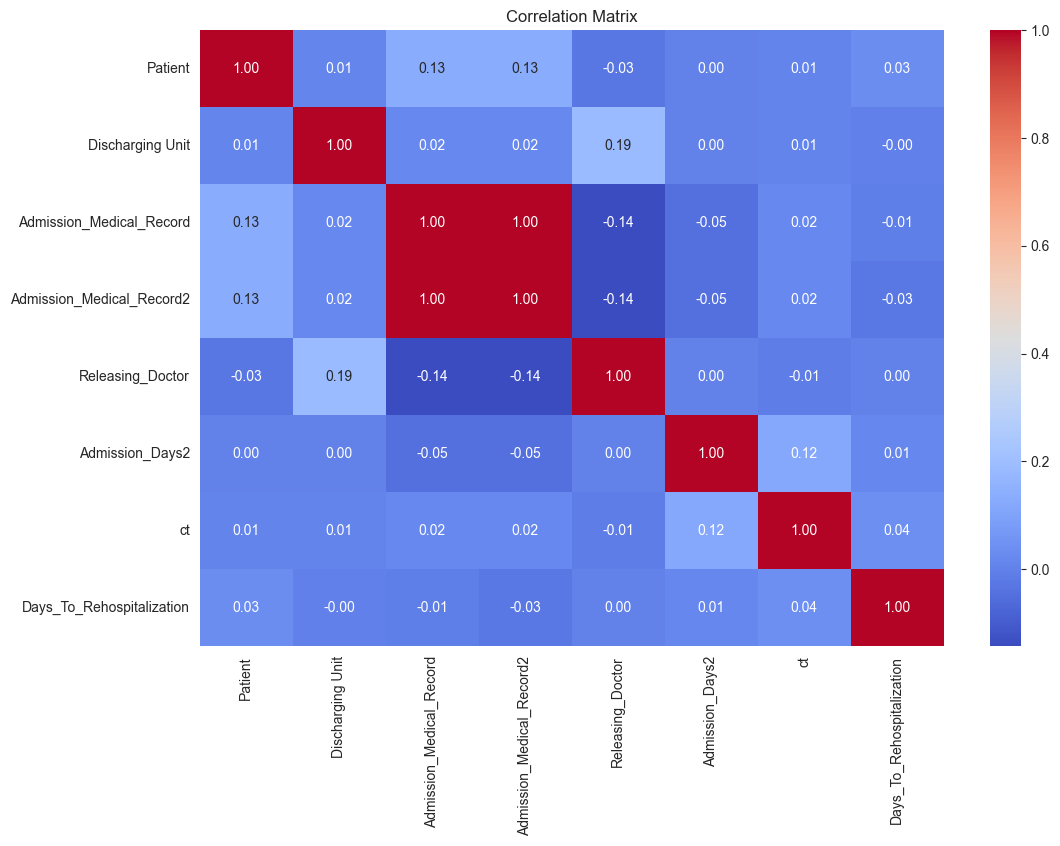

In [91]:
discharging_unit_vs_rehospitalization_time_eda = GenericEDA(df= clean_hospitazation2_df_with_rehospitalization_time_discharging_unit_combined_labeled_encoded)
discharging_unit_vs_rehospitalization_time_eda.plot_correlation_matrix()

We can see that all of our features have an extremely weak correlation to our target... It might suggest that a linear model (MLP) might not be the best choice to describe the relationship between the discharging unit and Days_To_Rehospitalization. Let's try that linear model (MLP) to see how bad it performs. The network will contain an input Linear layer, RelU activation function, and an output Linear layer. It will also contain hidden layers in the size of 10 , and will train to minimize the cross entropy loss function, and it will use an ADAM optimizer. it will train on 100 epochs with a learning rate of 0.01 . We will also compare it to other models:


### Linear model 
***

In [92]:
discharging_unit_train,discharging_unit_test, rehospitalization_time_train , rehospitalization_time_test = classification_report_for_rehospitalization.prepare_data()   # train - test split
linear_model = classification_report_for_rehospitalization.train_model(X_train=discharging_unit_train, y_train =rehospitalization_time_train, input_size=1, num_classes=3)  # linear model
classification_report_for_rehospitalization.evaluate_model(model=linear_model, X_test=discharging_unit_test, y_test=rehospitalization_time_test)

Epoch [10/100], Loss: 1.0996
Epoch [20/100], Loss: 1.0985
Epoch [30/100], Loss: 1.0984
Epoch [40/100], Loss: 1.0980
Epoch [50/100], Loss: 1.0980
Epoch [60/100], Loss: 1.0979
Epoch [70/100], Loss: 1.0978
Epoch [80/100], Loss: 1.0978
Epoch [90/100], Loss: 1.0978
Epoch [100/100], Loss: 1.0978
              precision    recall  f1-score   support

           0       0.32      0.45      0.37       873
           1       0.34      0.17      0.23       895
           2       0.33      0.36      0.35       907

    accuracy                           0.33      2675
   macro avg       0.33      0.33      0.31      2675
weighted avg       0.33      0.33      0.31      2675



We can see that we got accuracy of 33% (which is equivalent to just randomly assign a class to an observation, since we have 3 classes. So, as expected, the linear model performed poorly. Now, let's try another approach. 


### Logistic classifier
***

Next thing we tried is a logistic classifier. It is similar to the MLP we used earlier. only that he has an extra softmax layer after the output layer. The training procedure and parameters remain the same.

In [93]:
logistic_classification_report = LogisticClassificationPipeline(df=clean_hospitazation2_df_with_rehospitalization_time_discharging_unit_combined_labeled_encoded,features=['Discharging Unit'], target='Days_To_Rehospitalization')
logistic_model = logistic_classification_report.train_model(X_train=discharging_unit_train, y_train=rehospitalization_time_train, input_size=1, num_classes=3)
logistic_classification_report.evaluate_model(model=logistic_model, X_test=discharging_unit_test, y_test=rehospitalization_time_test)

Epoch [10/100], Loss: 1.0992
Epoch [20/100], Loss: 1.0988
Epoch [30/100], Loss: 1.0986
Epoch [40/100], Loss: 1.0984
Epoch [50/100], Loss: 1.0983
Epoch [60/100], Loss: 1.0982
Epoch [70/100], Loss: 1.0982
Epoch [80/100], Loss: 1.0981
Epoch [90/100], Loss: 1.0980
Epoch [100/100], Loss: 1.0980
              precision    recall  f1-score   support

           0       0.32      0.22      0.26       873
           1       0.32      0.38      0.35       895
           2       0.33      0.36      0.35       907

    accuracy                           0.32      2675
   macro avg       0.32      0.32      0.32      2675
weighted avg       0.32      0.32      0.32      2675



we can see that the softmax function did not change much... Let's try Resnet:

In [94]:
resnet_classification_report = ResnetClassificationPipeline(df=clean_hospitazation2_df_with_rehospitalization_time_discharging_unit_combined_labeled_encoded,features=['Discharging Unit'], target='Days_To_Rehospitalization')
resnet_model = resnet_classification_report.train_model(X_train=discharging_unit_train, y_train=rehospitalization_time_train, input_size=1, num_classes=3)
resnet_classification_report.evaluate_model(model=resnet_model, X_test=discharging_unit_test, y_test=rehospitalization_time_test)

Epoch [10/100], Loss: 1.1069
Epoch [20/100], Loss: 1.1001
Epoch [30/100], Loss: 1.0987
Epoch [40/100], Loss: 1.0983
Epoch [50/100], Loss: 1.0982
Epoch [60/100], Loss: 1.0982
Epoch [70/100], Loss: 1.0981
Epoch [80/100], Loss: 1.0981
Epoch [90/100], Loss: 1.0981
Epoch [100/100], Loss: 1.0981
              precision    recall  f1-score   support

           0       0.32      0.65      0.43       873
           1       0.00      0.00      0.00       895
           2       0.32      0.33      0.33       907

    accuracy                           0.32      2675
   macro avg       0.22      0.33      0.25      2675
weighted avg       0.22      0.32      0.25      2675



C:\DS2-final_project\data-science2-lab-final-project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DS2-final_project\data-science2-lab-final-project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\DS2-final_project\data-science2-lab-final-project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

We can see that even with Resnet we don't get good results, So it could be that the model is simply suffering from underfitting and needs to be trained on more features in order to produce good results. We will stick to the MLP model since it gave us the best results.

#### Visualization
***

C:\DS2-final_project\data-science2-lab-final-project\src\team_1\hospital_models\generic_torch_model.py:210: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_true, palette="viridis")
C:\DS2-final_project\data-science2-lab-final-project\src\team_1\hospital_models\generic_torch_model.py:218: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_pred, palette="viridis")


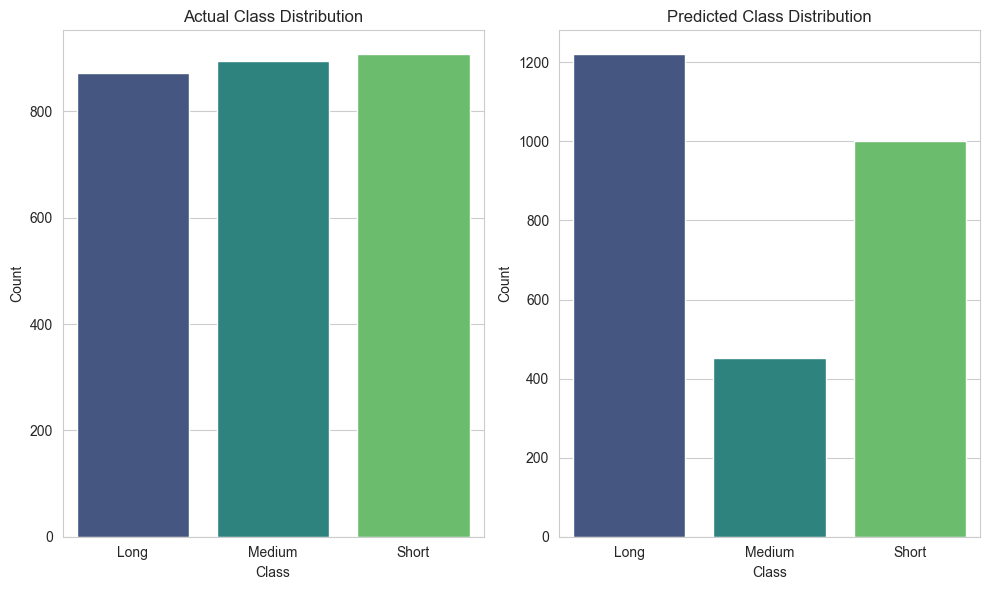

In [95]:
visualization_for_MLP = ClassificationVisualization()
_ , rehospitalization_time_pred = torch.max(linear_model.forward(discharging_unit_test),1)
visualization_for_MLP.plot_countplot(y_true=rehospitalization_time_test, y_pred=rehospitalization_time_pred, class_names =['Long', "Medium", 'Short'])

From this graph we can see that most mistakes are Medium that was classified as either Short or Long, and Short that was classified as probably Long.

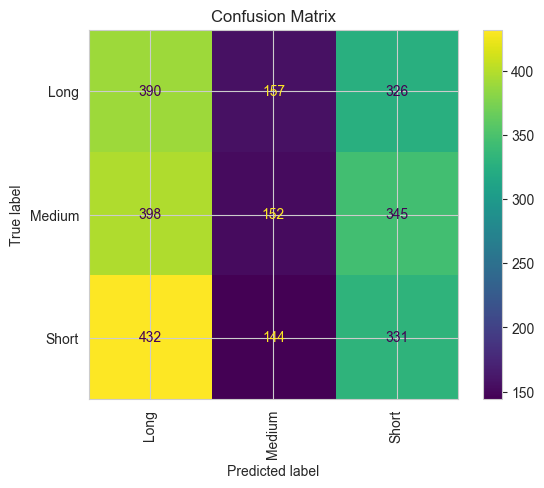

In [96]:
visualization_for_MLP.plot_confusion_matrix(y_true=rehospitalization_time_test, y_pred=rehospitalization_time_pred, class_names =['Long', "Medium", 'Short'])